## Bibliotecas

In [ ]:
import os
import time as tm
import pandas as pd
import numpy as np
import re
import pyodbc as odbc
import warnings as w

In [ ]:
w.filterwarnings('ignore')

## Variáveis

### Limite de Arquivos Processados e Ação

Define o número máximo de arquivos a serem processados nesta execução

In [ ]:
limite_arquivos = 200

Variável que indica qual ação será executada neste momento

0 = Salvar arquivo Excel;

1 = Executar o insert;

*Qualquer outro valor = Apenas gerar o dicionário contendo os dados dos arquivos.

In [ ]:
executar_acao = 1

caminho_arquivo_conferencia = r'\caminho_arquivo_conferencia'

### Variáveis Gerais

Relacionadas aos arquivos excel de orçamentação

Arquivo de exemplo:

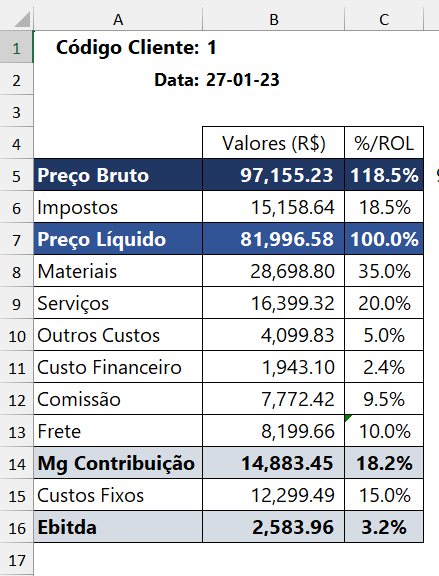

In [ ]:
pasta_orcamentos = r'\pasta_orcamentos'
padrao_nome_arq = r'Orçamento-\d+'
padrao_num = r'-(\d+)'

#Linhas da planilha
linha_min = 3
linha_max = 50

#Relativas à informação do cliente e data de orçamentação
lin_min_inf_orc = 0
lin_max_cd = 4
range_inf_orc = 'A:D'
lin_final_inf_orc = lin_max_cd - lin_min_inf_orc

#Relativas à tabela contendo os dados de precificação
lin_min_tab_dados = 3
lin_max_tb = 50
range_tab_dados = 'A:F'
lin_final_tab_dados = lin_max_tb - lin_min_tab_dados

Relativas às colunas das tabelas relacionadas no banco de dados 

In [ ]:
numero_orcamento = 'NUM_ORC'
versao_orcamento = 'VERSAO'
data_orcamento = 'DATA'
sur_key_cliente = 'SK_CLIENTE'
cod_cliente = 'COD_CLIENTE'
orc_consolidado = 'CONSOLIDADO'
nome_item_orcamento = 'ITEM'
cod_item_orcamento = 'COD_ITEM'
valor_item_orc = 'VALOR'

tabela_fato_orcamento = 'orcamentacao.fato_orcamento'

Relativas aos logs de execução

In [ ]:
pasta_logs = r'\pasta_logs'

arquivos_manipulados = 'Arquivos Manipulados.xlsx'
arq_log_erros = 'Log Erros.xlsx'

caminho_arquivos_manipulados = pasta_logs + '\\' + arquivos_manipulados
caminho_log_erros = pasta_logs + '\\' + arq_log_erros

De conexão ao banco de dados

In [ ]:
servidor = 'servidor'
banco_dados = 'banco_dados'
usuario = 'usuario'
senha = 'senha'
driver = '{ODBC Driver 18 for SQL Server}'

string_conexao = f'''
    Driver={driver};
    Server={servidor};
    Database={banco_dados};
    Uid={usuario};
    Pwd={senha};
'''

### Valores Padrões

Valores encontrados na análise exploratória dos arquivos de orçamentação e que deverão nortear a formação dos dataframes

In [ ]:
colunas_datas_dim_cliente = ['DT_INICIO', 'DT_FIM']

col_padroes_inf_orc = (0, 1, 2, 3)

inic_padrao_inf_orc = ('Código Cliente:', 'Cliente:', 'Cód. Cliente:')

final_padrao_inf_orc = ('Data:', 'Dt Orç')

col_padroes_tab_dados = (0, 1, 2)

inic_padrao_tab_dados = ('Preço Bruto', 'Peço Final', 'Receita Bruta', 'Preço Final')

final_padrao_tab_dados = ('Ebitda', 'Lucro')

Dicionário que renomeará a descrição dos itens nos arquivos de orçamentação visando cruzá-los com a tabela de Dimesão Itens

In [ ]:
conversao_itens = {
    'Acompanhamento': 'Av. Técnica',
    'Assistência Técnica': 'Ass.Técnica',
    'Avaliação Técnica': 'Av. Técnica',
    'Custo Financeiro': 'Custo Fin.',
    'Lucro': 'Ebitda',
    'MC': 'Margem C.',
    'Margem': 'Margem C.',
    'Mg Contribuição': 'Margem C.',
    'Outros Custos': 'Outros',
    'Peço Final': 'Preço Bruto',
    'Preço Final': 'Preço Bruto',
    'Preço Líquido': 'Preço Líq.',
    'Receita Bruta': 'Preço Bruto',
    'Receita Líquida': 'Preço Líq.'
}

## Estruturas de dados

In [ ]:
lista_arquivos = []
lista_abas = []
dados_arquivos = {}
lista_itens_geral = {}
campos_calculados = []
arquivo_insert = {}

In [ ]:
arquivo_manip = []
status_arq = []

log_arquivos_manipulados = {'ARQUIVO': arquivo_manip, 'STATUS_INSERT': status_arq}

In [ ]:
lista_arquivo = []
lista_etapa_erro = []
lista_tipo_erro = []
lista_msg_erro = []
lista_comando_insert = []

log_erros = {'ARQUIVO': lista_arquivo, 'ETAPA': lista_etapa_erro, 'TIPO_ERRO': lista_tipo_erro, 'MENSAGEM_ERRO': lista_msg_erro, 'COMANDO_INSERT': lista_comando_insert}

## Funções

### Arquivos de Orçamentação

Realizará a criação dos dataframes a partir das planilhas Excel 

In [ ]:
def fx_cria_dataframe(
    caminho_arq: str, 
    aba: str, 
    range_colunas: tuple, 
    linha_inicial: int, 
    linha_final: int, 
    colunas_padroes: tuple, 
    inicio_padrao: tuple, 
    final_padrao: tuple,
    qtd_coluna_Final: int
) -> (pd.DataFrame, int, int):        
        
        df = pd.read_excel(
            caminho_arq, 
            sheet_name = aba, 
            usecols = range_colunas, 
            skiprows = linha_inicial, 
            nrows = linha_final, 
            header = None
        )

        #Filtra apenas os registros que contém algum valor em quaisquer das colunas
        registros_nao_nulos = df.notna().any(axis = 1)
        df = df[registros_nao_nulos]
        df.reset_index(drop = True, inplace = True)

        idx_col_inicial = None

        #A partir do range padrão de colunas...
        for col in colunas_padroes:
            #Transforma o conteúdo das colunas num dicionário, onde as chaves são os índices e o conteúdo de cada linha são os valores
            valores_coluna = df[col].to_dict()

            for k, v in valores_coluna.items():
                #Verifica se algum dos valores da coluna está no range de "início" padrão do frame 
                if v in inicio_padrao:
                    #Caso sim, guarda o índice de início, bem como o nome da coluna onde ele foi encontrado 
                    idx_inicio_tabela = k
                    idx_col_inicial = df.columns.get_loc(col)

                    #Consequentemente, se o 1º registro foi encontrado, o último também estará nesta mesma coluna
                    for k, v in valores_coluna.items():
                        #Quando encontrado, guarda-se também o seu índice 
                        if v in final_padrao:
                            idx_final_tabela = k + 1

                    break
            

            if idx_col_inicial:
                break

        #A partir da quantidades de colunas que o frame terá, busca-se o índice da última coluna
        idx_col_final = idx_col_inicial + qtd_coluna_Final

        #Define o dataframe com as variáveis mapeadas anteriormente
        df_dados = df.iloc[idx_inicio_tabela:idx_final_tabela, idx_col_inicial:(idx_col_final + 1)]
        
        return df_dados, idx_col_inicial, idx_col_final

Fará o tratamento dos dados de cabeçalho

In [ ]:
def fx_trata_dados_cabecalho(          
    arquivo: str,            
    df: pd.DataFrame, 
    aba: str, 
    coluna_inicial: int, 
    coluna_final: int, 
    df_dimensao_scd: pd.DataFrame
) -> pd.DataFrame:

        #Altera o nome das variáveis coletadas
        df.iloc[0, 0] = cod_cliente
        df.iloc[1, 0] = data_orcamento

        #Insere novas variáveis
        df = pd.concat(
            [
                df, 
                pd.DataFrame(
                    {
                        coluna_inicial: [numero_orcamento], 
                        coluna_final: [int(re.search(padrao_num, arquivo).group(1))]
                    }
                ),
                pd.DataFrame(
                    {
                        coluna_inicial: [versao_orcamento], 
                        coluna_final: [int(aba.replace('V',''))]
                    }
                ),
                pd.DataFrame(
                    {
                        coluna_inicial: [orc_consolidado], 
                        coluna_final: ['S' if 'consolidado' in arquivo.lower() else 'N'][0]
                    }
                )        
            ], ignore_index = True
        )

        #Realiza um pivô, colando as variáveis como colunas
        df = df.T.rename(columns = df.iloc[:, 0]).reset_index(drop = True)
        df.drop(0, inplace = True)

        df[data_orcamento] = pd.to_datetime(df[data_orcamento])

        cliente = df[cod_cliente].values[0]
        data_orc = df[data_orcamento].values[0]

        #Pesquisa a surrogate key do cliente, baseado na data do orçamento
        query = 'COD_CLIENTE == @cliente & (@data_orc >= DT_INICIO & ((DT_FIM == "NaT") | (@data_orc < DT_FIM)))'
        cod = df_dimensao_scd.query(query)[sur_key_cliente].values[0]

        df[sur_key_cliente] = cod

        colunas_integer = [numero_orcamento, versao_orcamento, sur_key_cliente]
        df[colunas_integer] = df[colunas_integer].astype(np.int64)

        #Salva a data do orçamento como texto, porém no formato yyyy-mm-dd, preparando-a para inserção no banco de dados
        df[data_orcamento] = df[data_orcamento].dt.strftime('%Y-%m-%d')

        ordenar_colunas = [
            numero_orcamento,
            versao_orcamento,
            data_orcamento,
            sur_key_cliente,
            orc_consolidado
        ]

        df = df[ordenar_colunas]

        return df

Fará o tratamento dos dados de orçamentação (itens de precificação e valores)

In [ ]:
def fx_trata_dados_orcamento(
    df: pd.DataFrame, 
    df_item: pd.DataFrame,
    renomear_itens: dict,
    coluna_inicial: str, 
    coluna_final: str
) -> pd.DataFrame:

        coluna_itens = 'DESCRICAO_ABREV'
        coluna_valores = valor_item_orc

        renomear_colunas = {
            coluna_inicial: coluna_itens,
            coluna_final: coluna_valores
        }

        df.rename(columns = renomear_colunas, inplace = True)

        df['DESCRICAO_ABREV'].replace(renomear_itens, inplace = True)

        #Busca o código dos itens de orçamentação
        df = df.merge(df_item, how='inner', on = 'DESCRICAO_ABREV')

        df = df[[cod_item_orcamento, coluna_valores]]

        df[coluna_valores] = df[coluna_valores].apply(lambda x: round(x, 4))

        return df

Realizará a mescla dos dataframes de cabeçalho e dados de orçamentação

In [ ]:
def fx_mescla_arquivos(
    dados: dict,
    dataframe_1: str,
    dataframe_2: str
) -> pd.DataFrame:
            
        df_geral = pd.DataFrame()    
        for df in dados.values():
            df_arq = df[dataframe_1].merge(df[dataframe_2], how = 'cross')
            df_geral = pd.concat([df_geral, df_arq], axis = 0, ignore_index = True)
    
        return df_geral

### Logs de Execução

Mapeará os erros encontrados durante a execução deste script

In [ ]:
def fx_mapeia_erros(
    arquivo_log_erros: pd.DataFrame,
    arquivo_orc_manipulados: pd.DataFrame,
    arquivo: str,
    etapa_erro: str,
    erro: str,
    cod_insert: str
)-> dict:
        col_log_erro = list(log_erros.keys())
        col_log_manip = list(log_arquivos_manipulados.keys())        

        arquivo_log_erros[col_log_erro[0]].append(arquivo)
        arquivo_log_erros[col_log_erro[1]].append(etapa_erro)
        arquivo_log_erros[col_log_erro[2]].append(type(erro))
        arquivo_log_erros[col_log_erro[3]].append(erro)
        arquivo_log_erros[col_log_erro[4]].append(cod_insert)
                
        arquivo_orc_manipulados[col_log_manip[0]].append(arquivo)
        #E = Arquivo processado com Erros 
        arquivo_orc_manipulados[col_log_manip[1]].append('E')

        return arquivo_log_erros, arquivo_orc_manipulados

Salvará diversos dataframes no formato .xlsx

In [ ]:
def fx_salva_arquivos_excel(
    caminho_arquivo_historico: str,
    df_dados_atuais: pd.DataFrame
):
    #Resgata o arquivo já criado, coloca seus dados num dataframe e o concatena com os dados novos
    df_arq_historico = pd.read_excel(caminho_arquivo_historico)
    df_arq_atualizado = pd.concat([df_arq_historico, df_dados_atuais], ignore_index=False)
    df_arq_atualizado.drop_duplicates(ignore_index = True, inplace = True)
    #Salva o arquivo atualizado no mesmo local
    df_arq_atualizado.to_excel(caminho_arquivo_historico, sheet_name = 'dados', index = False)

### Banco de Dados

Fará a conexão com o banco de dados Azure SQL Server, utilizando uma string de conexão, e realizará um comando DQL

In [ ]:
def fx_consulta_bd(
    string_conexao: str, 
    query: str
) -> pd.DataFrame:
    
        with odbc.connect(string_conexao) as conexao:
            with conexao.cursor() as cursor:
                #Cria um cursor e executa uma query
                cursor.execute(query)
                #O retorno desta query é inserido num objeto, o qual posteriormente é transformado num dataframe
                retorno = cursor.fetchall()
                colunas = [c[0] for c in cursor.description]
                df = pd.DataFrame.from_records(retorno, columns = colunas)

        return df

Realizará a construção dos scripts de insert no banco de dados para cada arquivo de orçamentação

In [ ]:
def fx_cria_inserts(
    dados: pd.DataFrame
) -> dict:
        for arquivo, conteudo in dados.items():
            arquivo_insert[arquivo] = []

            #Separa cada valor coletado em variáveis
            cont_cabecalho = conteudo['CABECALHO'].to_dict(orient = 'records')[0]
            num_orc = cont_cabecalho[numero_orcamento]
            v_orc = cont_cabecalho[versao_orcamento]
            data_orc = cont_cabecalho[data_orcamento]
            sk_cliente = cont_cabecalho[sur_key_cliente]
            orc_cons = cont_cabecalho[orc_consolidado]

            cont_orcamento = conteudo['DADOS_ORC']
            
            for i, v in cont_orcamento.iterrows():
                item = int(v[cod_item_orcamento])
                valor = v[valor_item_orc]

                insert = f"INSERT INTO {tabela_fato_orcamento} VALUES({num_orc}, {v_orc}, '{data_orc}', {sk_cliente}, '{orc_cons}', {item}, {valor});"
                
                arquivo_insert[arquivo].append(insert)

        return arquivo_insert

Executará os scripts de insert no banco de dados

In [ ]:
def fx_insere_dados_bd_gera_logs(
    string_conexao: str,    
    arquivo_comandos_insert: dict,
    arquivo_log_erros: dict,
    arquivo_orc_manipulados: dict
)-> pd.DataFrame:

        col_log_manip = list(log_arquivos_manipulados.keys())  
        
        #Se conecta ao banco de dados via ODBC e cria um cursor    
        with odbc.connect(string_conexao) as conexao:
            with conexao.cursor() as cursor:
                
                cont_inserts = sum(len(v) for v in arquivo_insert.values())
                print(f'{cont_inserts} inserts criados\n')
                cont = 1
                    
                #Itera sobre os insert de cada arquivo de orçamentação 
                for arq, cod in arquivo_comandos_insert.items():
                    
                    #Esta variável terá a função de testar se a execução do script de insert resultou em erro ou não
                    erro = 'N' 
                    #Itera sobre cada comando insert e tenta executá-lo
                    for i in cod:
                        try:
                            print(f'Executando {cont} de {cont_inserts};')
                            cursor.execute(i)

                        #Caso ocorra algum erro, este exception fará o seu mapeamento
                        #Em qual arquivo / Qual o tipo do erro / Qual a descrição do erro / Em qual comando insert
                        except Exception as e:
                            erro = 'S'
                            arquivo_log_erros, arquivo_orc_manipulados = \
                            fx_mapeia_erros(
                                arquivo_log_erros = arquivo_log_erros,
                                arquivo_orc_manipulados = arquivo_orc_manipulados,
                                arquivo = arq,
                                etapa_erro = 'Inserts BD',
                                erro = e,
                                cod_insert = i
                            )
                            pass

                        #Pausa de 0.5s de um insert para outro
                        finally:
                            tm.sleep(0.5)
                            cont += 1

                    if erro == 'N': 
                        arquivo_orc_manipulados[col_log_manip[0]].append(arq)
                        #T = Arquivo Totalmente processado
                        arquivo_orc_manipulados[col_log_manip[1]].append('T')

            #Monta dataframes para os arquivos auxiliares: arquivos manipulados e log de erros
            df_arq_manip = pd.DataFrame(arquivo_orc_manipulados)
            df_erros = pd.DataFrame(arquivo_log_erros)
            
        return df_arq_manip, df_erros

## Execução

### Dados do BD

Se conecta ao banco de dados e busca os dados da tabela dimensao_cliente

In [ ]:
query_tabela_dim_cliente = '''
SELECT [SK_CLIENTE]
      ,[COD_CLIENTE]
      ,CONVERT(varchar, [DT_INICIO], 105) DT_INICIO
      ,CONVERT(varchar, [DT_FIM], 105) DT_FIM
  FROM [orcamentacao].[dimensao_cliente]
'''

df_dim_cliente = \
fx_consulta_bd(
    string_conexao = string_conexao,
    query = query_tabela_dim_cliente
)

df_dim_cliente[colunas_datas_dim_cliente] = df_dim_cliente[colunas_datas_dim_cliente].apply(pd.to_datetime, format = '%d-%m-%Y')

tm.sleep(1)

Se conecta ao banco de dados e busca os dados da tabela dimensao_item_orcamentacao

In [ ]:
query_tabela_dim_item_orc = '''
SELECT [COD_ITEM]
      ,[DESCRICAO_ABREV]
  FROM [orcamentacao].[dimensao_item_orcamentacao]
  WHERE [CALCULADO] = 'N'
'''

df_dim_item_orc = \
fx_consulta_bd(
    string_conexao = string_conexao,
    query = query_tabela_dim_item_orc
)

tm.sleep(1)

### Arquivos Processados

Busca a relação de arquivos que já foram manipulados

In [ ]:
lista_arq_manipulados = pd.read_excel(caminho_arquivos_manipulados, header = None,  skiprows = 1)

if lista_arq_manipulados.shape[0] > 0:
    lista_arq_manipulados = lista_arq_manipulados[0].to_list()

A partir da pasta onde estão os arquivos de orçamentação, relaciona os que serão processados

In [ ]:
for arq in os.listdir(pasta_orcamentos):
    if re.match(padrao_nome_arq, arq) and arq not in lista_arq_manipulados:
        lista_arquivos.append(arq)

lista_arquivos = lista_arquivos[0:limite_arquivos]

#Exemplo:
#lista_arquivos = ['Orçamento-1034.xlsx']

### Bloco Principal

Processa cada arquivo

In [ ]:
for arq in lista_arquivos:
    caminho_arquivo = pasta_orcamentos + '\\' + arq

    #Acessa o arquivo excel e verifica qual é a última aba, da qual serão extarídos os dados
    try:
        with pd.ExcelFile(caminho_arquivo) as excel:
            aba_v_valida = max(excel.sheet_names)
    except Exception as e:
        log_erros, log_arquivos_manipulados = \
        fx_mapeia_erros(
            arquivo_log_erros = log_erros,
            arquivo_orc_manipulados = log_arquivos_manipulados,    
            arquivo = arq,
            etapa_erro = 'Leitura do Arquivo',
            erro = e,
            cod_insert = ''
        )
        next         

    try:
        df_cabecalho, col_inic_cabecalho, col_final_cabecalho = \
        fx_cria_dataframe(
            caminho_arq = caminho_arquivo, 
            aba = aba_v_valida, 
            range_colunas = range_inf_orc, 
            linha_inicial = lin_min_inf_orc, 
            linha_final = lin_final_inf_orc, 
            colunas_padroes = col_padroes_inf_orc, 
            inicio_padrao = inic_padrao_inf_orc, 
            final_padrao = final_padrao_inf_orc,
            qtd_coluna_Final = 1
        )
        
        df_dados_orc, col_inic_tab_dados, coluna_final_tab_dados = \
        fx_cria_dataframe(
            caminho_arq = caminho_arquivo, 
            aba = aba_v_valida, 
            range_colunas = range_tab_dados, 
            linha_inicial = lin_min_tab_dados, 
            linha_final = lin_final_tab_dados, 
            colunas_padroes = col_padroes_tab_dados, 
            inicio_padrao = inic_padrao_tab_dados, 
            final_padrao = final_padrao_tab_dados,
            qtd_coluna_Final = 1
        )
    
    except Exception as e:
        log_erros, log_arquivos_manipulados = \
        fx_mapeia_erros(
            arquivo_log_erros = log_erros,
            arquivo_orc_manipulados = log_arquivos_manipulados,    
            arquivo = arq,
            etapa_erro = 'Criação dos Dataframes',
            erro = e,
            cod_insert = ''
        )
        pass        

    else:
        try:        
            df_cabecalho = \
            fx_trata_dados_cabecalho(
                arquivo = arq,
                df = df_cabecalho,
                aba =  aba_v_valida,
                coluna_inicial = col_inic_cabecalho, 
                coluna_final = col_final_cabecalho, 
                df_dimensao_scd = df_dim_cliente
            )

            df_dados_orc = \
            fx_trata_dados_orcamento(
                df = df_dados_orc,
                df_item = df_dim_item_orc,
                renomear_itens = conversao_itens,
                coluna_inicial = col_inic_tab_dados,
                coluna_final = coluna_final_tab_dados
            )

        except Exception as e:
            log_erros, log_arquivos_manipulados = \
            fx_mapeia_erros(
                arquivo_log_erros = log_erros,
                arquivo_orc_manipulados = log_arquivos_manipulados,    
                arquivo = arq,
                etapa_erro = 'Tratamento dos Dados',
                erro = e,
                cod_insert = ''
            )
            pass

        else:
            #Cria um dicionário para cada arquivo, o qual conterá os dados de cabeçalho e orçamentação
            dados_arquivos[arq] = {'CABECALHO': df_cabecalho, 'DADOS_ORC': df_dados_orc}

    finally: 
        #Apenas printa o arquivo processado, para fins de acompanhamento  
        print(arq)
        tm.sleep(1)

### Bloco Secundário

Baseado na ação escolhida

In [ ]:
if executar_acao == 0:
    df_tabela_excel = \
    fx_mescla_arquivos(
        dados = dados_arquivos, 
        dataframe_1 = 'CABECALHO', 
        dataframe_2 = 'DADOS_ORC'
    )

    fx_salva_arquivos_excel(
        caminho_arquivo_historico = caminho_arquivo_conferencia,
        df_dados_atuais = df_tabela_excel
    )

elif executar_acao == 1:
    arquivo_insert = \
    fx_cria_inserts(
        dados = dados_arquivos
    )

    tm.sleep(1)
    
    df_arquivos_manipulados, df_erros_insert = \
    fx_insere_dados_bd_gera_logs(
        string_conexao = string_conexao,
        arquivo_comandos_insert = arquivo_insert,
        arquivo_log_erros = log_erros,
        arquivo_orc_manipulados = log_arquivos_manipulados    
    )

    fx_salva_arquivos_excel(
    caminho_arquivo_historico = caminho_arquivos_manipulados,
    df_dados_atuais = df_arquivos_manipulados
    )

    if df_erros_insert.shape[0] > 0:
        fx_salva_arquivos_excel(
            caminho_arquivo_historico = caminho_log_erros,
            df_dados_atuais = df_erros_insert
        )    